# New experiments to improve the performance of the model

In this notebook we are going to rerun the decision tree model with the following changes:
    
    1. We exclude the predictors that are highly correlated among each other
    2. We exclude the outliers
    3. We make sure that training and test datasets are statistically similar

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt 
import seaborn as sns

file_path=r'C:\Users\Marco\Desktop\TU Dublin\Programming for Big Data - H6018\2nd Assignment\data'
file_name='/credit_card_default.xls'

df = pd.read_excel(file_path+file_name, encoding = "ISO-8859-1")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#checking duplicates for ID and drop it
df.ID.duplicated().sum()
df.drop(['ID'], axis=1, inplace=True)
#rename columns
df = df.rename(columns = {'default payment next month' : 'def_next_month', 
                          'PAY_0' : 'PAY_1'})
df.def_next_month.value_counts()
#Correct data inconsistencies 
# MARRIAGE = 0 is deleted
df = df.drop(df[df['MARRIAGE']==0].index)
# EDUCATION = 0, 5 and 6 are deleted
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
#Fixing PAY variables
for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  # categories -2,-1 are grouped into a single class -1: pay duty   
  filter = (df[att] == -2) | (df[att] == -1) 
  df.loc[filter, att] = -1
  df[att] = df[att].astype('int64')
  filter = (df[att] >= 0)
  df.loc[filter, att] = df.loc[filter, att] + 1

In [90]:
df.shape

(29601, 24)

## 1.Removing predictors correlated among each other

From the data exploration part, we saw that the PAY, BILL_AMT and PAY_AMT are higly correlated among each other.

We can try to keep them only after one month to see if the performance of the model increases.
We decided to keep the first month because PAY_1 has the highest correlation with the target variable.

In [4]:
df_nocorr = df.drop(['PAY_2', 'PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2',
                               'BILL_AMT3','BILL_AMT4','BILL_AMT5', 'BILL_AMT6', 'PAY_AMT2', 'PAY_AMT3',
                               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],axis=1)
df_nocorr.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_AMT1,def_next_month
0,20000,2,2,1,24,3,0,1
1,120000,2,2,2,26,-1,0,1
2,90000,2,2,2,34,1,1518,0
3,50000,2,2,1,37,1,2000,0
4,50000,1,2,1,57,-1,2000,0


In [91]:
df_nocorr.shape

(29601, 8)

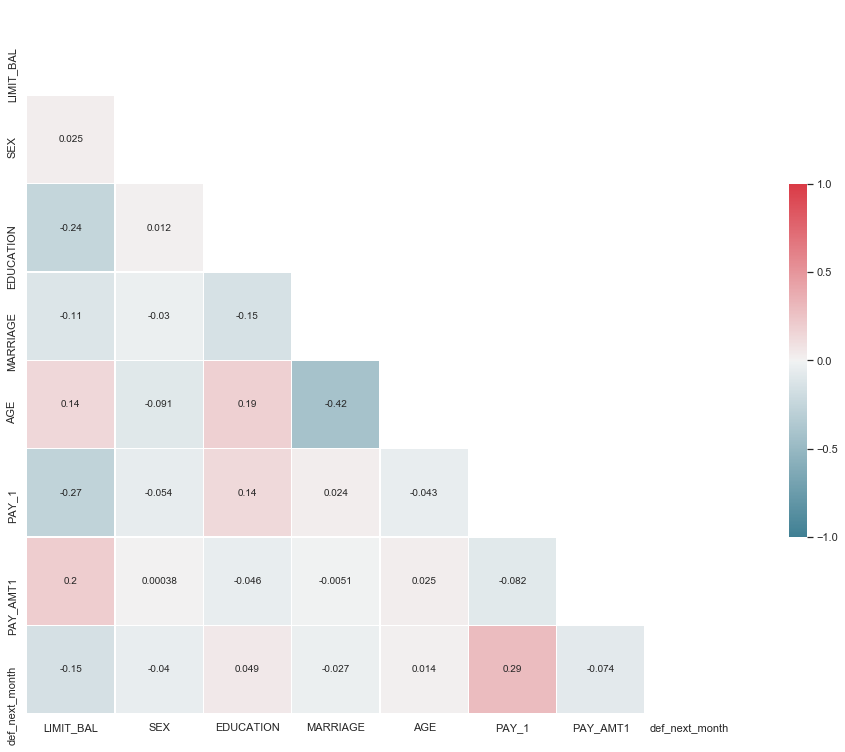

In [5]:
# Correlation matrix
sns.set(style="white", font_scale=1)
corr = df_nocorr.corr() 
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cmap=cmap, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 10})
cbar=ax.collections[0].colorbar
cbar.set_ticks([-1, -0.50, 0, 0.50, 1])

## 2.Removing Outliers

We saw in our EDA that there are some outliers in the dataset. These can be very influencial on training models. As such, we might consider removing them and comparing results.

We know via Chebyshev's Theorem (https://tinyurl.com/ckanez5s) that for any distribution, at least 88% of the data is contained within 3 standard deviations of the mean.

Here we come to a trade-off. By removing outliers, theoretically we are left with at least 88% of the data, and this might help the accuracy of the models. On the other hand, it might be these outliers which in a banking setting, are contributing disproportionately to the revenue, and hence we would want to focus a lot on these customers.

In a real-world setting, far more complex models would be used which would be tailored specially to these outlier clients. For the purposes of our modeling, we will remove all entries where at least one variable has an entry more than three times the standard deviation of the mean of that variable, and when we model, we can compare the full dataset and results to the results from the dataset with the outliers removed.

The proportion of records deleted is only 2.2%, it is probably not going to impact that much.

In [5]:
# drop response variables and categorical variables (age)
df_numeric = df_nocorr.drop(['def_next_month','AGE', 'SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
# standardise the numeric variables
df_standard = (df_numeric - df_numeric.mean())/df_numeric.std()
# get the index of any observations which have at least one variable entry < 3, as a list
outlier_list = df_standard[(np.abs(df_standard)>3).any(1)].index.tolist()
# remove the outliers via index
df_outliers_removed = df_nocorr.drop(index=outlier_list)

In [6]:
1-(len(df_outliers_removed)/len(df_standard))

0.02178980439850009

In [123]:
df_outliers_removed.shape

(28956, 8)

In [124]:
df_outliers_removed.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_AMT1,def_next_month
0,20000,2,2,1,24,3,0,1
1,120000,2,2,2,26,-1,0,1
2,90000,2,2,2,34,1,1518,0
3,50000,2,2,1,37,1,2000,0
4,50000,1,2,1,57,-1,2000,0


In [126]:
df_outliers_removed.isnull().any()

LIMIT_BAL         False
SEX               False
EDUCATION         False
MARRIAGE          False
AGE               False
PAY_1             False
PAY_AMT1          False
def_next_month    False
dtype: bool

In [7]:
# Set 'category' type to categorical attributes
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  df_outliers_removed[att] = df_outliers_removed[att].astype('category')

# one-hot encoding
df_encoded=pd.concat([pd.get_dummies(df['SEX'], prefix='SEX'),
                pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'), 
                pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                df_outliers_removed],axis=1)
# drop original columns
df_encoded.drop(['EDUCATION'],axis=1, inplace=True)
df_encoded.drop(['SEX'],axis=1, inplace=True)
df_encoded.drop(['MARRIAGE'],axis=1, inplace=True)

# drop response variable and the hot encoded variables
df_drop_var = df_encoded.drop(['def_next_month', 'SEX_1','SEX_2','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4',
                               'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3'],axis=1)

df_scaled = df_drop_var/df_drop_var.std()

#concatenating the encoded variables with the scaled variables
df_encoded_only = df_encoded.iloc[:,:9]
df_prep = pd.concat([df_encoded_only, df_scaled, df.def_next_month],axis=1)

In [12]:
df_prep.head(5)

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,AGE,PAY_1,PAY_AMT1,def_next_month
0,0,1,0,1,0,0,1,0,0,0.159313,2.604301,2.328696,0.000000,1
1,0,1,0,1,0,0,0,1,0,0.955878,2.821326,-0.776232,0.000000,1
2,0,1,0,1,0,0,0,1,0,0.716909,3.689426,0.776232,0.237006,0
3,0,1,0,1,0,0,1,0,0,0.398283,4.014963,0.776232,0.312260,0
4,1,0,0,1,0,0,1,0,0,0.398283,6.185214,-0.776232,0.312260,0


In [132]:
df_prep.shape

(29601, 14)

In [133]:
df_prep.isnull().any()

SEX_1             False
SEX_2             False
EDUCATION_1       False
EDUCATION_2       False
EDUCATION_3       False
EDUCATION_4       False
MARRIAGE_1        False
MARRIAGE_2        False
MARRIAGE_3        False
LIMIT_BAL          True
AGE                True
PAY_1              True
PAY_AMT1           True
def_next_month    False
dtype: bool

We concatenated the numeric dataset without outliers (28.956 records) with the encoded categorical variables (29.601 records).


So, we have 645 records with the numerical variables that are null. 

This is a problem when we run the model, because we will get an error.


As we have seen before, this is equal to 2.2% of the original dataset, we can delete those records with NULL values.


In [8]:
df_prep_no_miss = df_prep.dropna()
df_prep_no_miss.shape

(28956, 14)

In [143]:
df_prep_no_miss.isnull().any()

SEX_1             False
SEX_2             False
EDUCATION_1       False
EDUCATION_2       False
EDUCATION_3       False
EDUCATION_4       False
MARRIAGE_1        False
MARRIAGE_2        False
MARRIAGE_3        False
LIMIT_BAL         False
AGE               False
PAY_1             False
PAY_AMT1          False
def_next_month    False
dtype: bool

## Train, Validation and Test Split

In [10]:
# resampling dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [11]:
oversamp = SMOTE(sampling_strategy = 0.35)
undersamp = RandomUnderSampler(sampling_strategy = 0.45)
pipeline = Pipeline(steps = [('over', oversamp),('under', undersamp)])

X, y = pipeline.fit_resample(df_prep_no_miss.drop(['def_next_month'],axis=1),df_prep_no_miss.def_next_month)

In [12]:
print(y.sum()/len(y))

0.3103529875764149


In [13]:
# Splitting Train, test dataset
from sklearn.model_selection import train_test_split

X_train, X_NOT_train, y_train, y_NOT_train = train_test_split(df_prep_no_miss.drop(['def_next_month'],axis=1),
                                                              df_prep_no_miss.def_next_month,test_size=0.33,
                                                                        random_state=101)

# split 30% groups into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_NOT_train,y_NOT_train,test_size=0.5,
                                                                    random_state=101)

Check all the shapes to make sure that everything has worked out okay.

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)

(19400, 13)
(4778, 13)
(4778, 13)
(4778,)
(4778,)


# 3. Checking statistical similarity between training and test datasets 

We want to be sure that, when splitting in training and test dataset, the distribution of the features has not been distorted due to the sampling procedure.

We can use Kolmogorov-Smirnov distance, in order to evaluate the difference between the two distributions.

In [15]:
from scipy import stats
from scipy.stats import ks_2samp

In [16]:
distances = list(map(lambda i : ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(X_train.shape[1])))

We can observe that almost all the variables are similarly statistically distributed, but MARRIAGE_1 shows quite high difference

In [17]:
for i in range(X_train.shape[1]):
  print(X_train.columns[i],distances[i])

SEX_1 0.012194551488135086
SEX_2 0.01219455148813503
EDUCATION_1 0.0005912192048607157
EDUCATION_2 0.00012753902120110627
EDUCATION_3 0.0005175352668803646
EDUCATION_4 0.000981215450540085
MARRIAGE_1 9.71376541105684e-05
MARRIAGE_2 0.0004722676528591263
MARRIAGE_3 0.0005694053069695837
LIMIT_BAL 0.010036658568266021
AGE 0.011945277539236965
PAY_1 0.009408262957800562
PAY_AMT1 0.01699449366296557


In order to minimize this distance, we can generate several couples of training/test datasets and choose the datasets that minimize the difference, by using random state.

We are going to try with 100 samplings.

In [18]:
X = df_prep_no_miss.drop(['def_next_month'], axis=1)
y = df_prep_no_miss.def_next_month

In [19]:
n_features = X.shape[1]

n_tries = 100

result = []

for random_state in range(n_tries):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# split 30% groups into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_NOT_train,y_NOT_train,test_size=0.5,
                                                                    random_state=random_state)

distances = list(map(lambda i : ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(n_features)))
sorted(distances)

[0.0004637190276342018,
 0.001226554330235774,
 0.003576921795735988,
 0.005109200879811593,
 0.006323601804370749,
 0.006323601804370804,
 0.008222403647913379,
 0.008649239102840323,
 0.009794354256720539,
 0.009875793433076041,
 0.012492131521698702,
 0.01521671442910355,
 0.01538904084145265]

We can observe that the distance between training and test dataset for the variable MARRIAGE_1 has decreased a lot.

In [20]:
feature = 'MARRIAGE_1'
ks_2samp(X_train.loc[:,feature],X_test.loc[:,feature]).statistic

0.008649239102840323

Model Implementation - Decision Tree

After 

- Excluding the predictors that are highly correlated among each other
- Excluding the outliers
- Making sure that training and test datasets are statistically similar
- Resampling

We re-run the model. Compared with the previous result, where we only have have implemented resampling,  we can observe how all the metrics have significantly increased.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report

In [22]:
tree1 = DecisionTreeClassifier()
tree1.fit(X_train, y_train)
pred1 = tree1.predict(X_val)
print('Decision Tree - NEW')
print(classification_report(pred1,y_val))
print('\n')

Decision Tree - NEW
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3753
           1       0.79      0.80      0.79      1025

    accuracy                           0.91      4778
   macro avg       0.87      0.87      0.87      4778
weighted avg       0.91      0.91      0.91      4778





Below we can see the comparison

In [25]:
file_path=r'C:\Users\Marco\Desktop\TU Dublin\Programming for Big Data - H6018\2nd Assignment\data'
file_name='/credit_card_default.xls'

df = pd.read_excel(file_path+file_name, encoding = "ISO-8859-1")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#checking duplicates for ID and drop it
df.ID.duplicated().sum()
df.drop(['ID'], axis=1, inplace=True)
#rename columns
df = df.rename(columns = {'default payment next month' : 'def_next_month', 
                          'PAY_0' : 'PAY_1'})
df.def_next_month.value_counts()
#Correct data inconsistencies 
# MARRIAGE = 0 is deleted
df = df.drop(df[df['MARRIAGE']==0].index)
# EDUCATION = 0, 5 and 6 are deleted
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
#Fixing PAY variables
for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  # categories -2,-1 are grouped into a single class -1: pay duty   
  filter = (df[att] == -2) | (df[att] == -1) 
  df.loc[filter, att] = -1
  df[att] = df[att].astype('int64')
  filter = (df[att] >= 0)
  df.loc[filter, att] = df.loc[filter, att] + 1
    
# Set 'category' type to categorical attributes
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  df[att] = df[att].astype('category')

# one-hot encoding
df_encoded=pd.concat([pd.get_dummies(df['SEX'], prefix='SEX'),
                pd.get_dummies(df['EDUCATION'], prefix='EDUCATION'), 
                pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE'),
                df],axis=1)
# drop original columns
df_encoded.drop(['EDUCATION'],axis=1, inplace=True)
df_encoded.drop(['SEX'],axis=1, inplace=True)
df_encoded.drop(['MARRIAGE'],axis=1, inplace=True)

# drop response variable and the hot encoded variables
df_drop_var = df_encoded.drop(['def_next_month', 'SEX_1','SEX_2','EDUCATION_1','EDUCATION_2','EDUCATION_3','EDUCATION_4',
                               'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3'],axis=1)

df_scaled = df_drop_var/df_drop_var.std()

#concatenating the encoded variables with the scaled variables
df_encoded_only = df_encoded.iloc[:,:9]

df_prep_old = pd.concat([df_encoded_only, df_scaled, df.def_next_month],axis=1)

# Splitting Train, test dataset
from sklearn.model_selection import train_test_split

X_train2, X_NOT_train2, y_train2, y_NOT_train2 = train_test_split(df_prep_old.drop(['def_next_month'],axis=1),
                                                                        df_prep_old.def_next_month,test_size=0.3,
                                                                        random_state=101)

# split 30% groups into validation and test sets
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_NOT_train2,y_NOT_train2,test_size=0.5,
                                                                    random_state=101)



tree2 = DecisionTreeClassifier()
tree2.fit(X_train2, y_train2)
pred2 = tree2.predict(X_val2)

print('Decision Tree - NEW')
print(classification_report(pred1,y_val))
print('\n')

print('Decision Tree - Old')
print(classification_report(pred2,y_val2))
print('\n')

Decision Tree - NEW
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3753
           1       0.79      0.80      0.79      1025

    accuracy                           0.91      4778
   macro avg       0.87      0.87      0.87      4778
weighted avg       0.91      0.91      0.91      4778



Decision Tree - Old
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3319
           1       0.43      0.37      0.40      1121

    accuracy                           0.72      4440
   macro avg       0.61      0.60      0.61      4440
weighted avg       0.70      0.72      0.71      4440





# Conclusion

The new experiments already contributed enough to achieve a satisfactory outcome. 
At this point it is not easy to say which one contributed the most.

Considering that the outliers removed were only 2.2%, and that we have also removed 15 variables that were correlated among each other. Probably, the feature selection has been one of the experiment which contributed the most.